In [1]:
# Import packages
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import dill, sys
import copy
import numpy as np
import matplotlib.pyplot as plt
import scarlet

import kuaizi as kz
from kuaizi.display import display_single, SEG_CMAP, display_scarlet_results_tigress
from kuaizi.detection import Data

import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column, Row, vstack, hstack
from astropy.coordinates import SkyCoord

from PIL import Image

sys.path.append('/home/jiaxuanl/Research/Packages/kuaizi/diezi/scarlet_modeling/script/')

In [3]:
env_dict = {'project': 'HSC', 'name': 'LSBG', 'data_dir': '/scratch/gpfs/jiaxuanl/Data'}
kz.utils.set_env(**env_dict)
kz.set_matplotlib(style='JL', usetex=True, dpi=100, fontsize=16)

In [4]:
GALARY = '/tigress/jiaxuanl/public_html/galary/'
name = 'upg'

### We have already made cuts in `NSA-structure-vanilla-cuts-all.ipynb`. Now we select UPGs, make visual inspection, and plot some useful figures

In [24]:
input_cuts_cat = Table.read('./Catalog/nsa_z001_004/lsbg_after_cuts_spergel_w_missed.fits')
from sample_cuts import post_process_cat_new_rbf
cuts_cat = post_process_cat_new_rbf(input_cuts_cat)

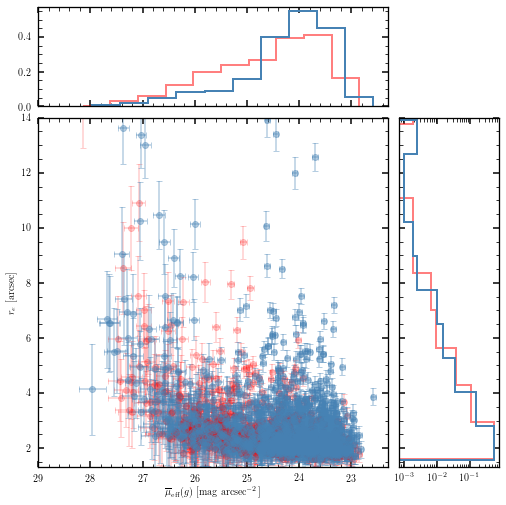

In [25]:
# Distribution of the full sample after junk cuts
fig = plt.figure(figsize=(8, 8))

gs = fig.add_gridspec(2, 2,  width_ratios=(7, 2), height_ratios=(2, 7),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)

ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
ax_histx.tick_params(axis="x", labelbottom=False)
ax_histy.tick_params(axis="y", labelleft=False)


red = (cuts_cat['g-i'].data > 0.8)

ax.errorbar(cuts_cat[red]['SB_eff_avg'][:, 0], 
            cuts_cat[red]['rhalf_spergel'], 
            xerr=cuts_cat[red]['SB_eff_avg_err'][:, 0],
            yerr=cuts_cat[red]['rhalf_spergel_err'],
            color='r', fmt='o', alpha=0.2)

ax.errorbar(cuts_cat[~red]['SB_eff_avg'][:, 0], 
            cuts_cat[~red]['rhalf_spergel'], 
            xerr=cuts_cat[~red]['SB_eff_avg_err'][:, 0],
            yerr=cuts_cat[~red]['rhalf_spergel_err'],
            color='steelblue', fmt='o', alpha=0.4)

ax.set_xlim(29, 22.3)
ax.set_ylim(1.3, 14)
ax.set_xlabel(r'$\overline{\mu}_{\rm eff}(g)\ [\rm mag\ arcsec^{-2}]$')
ax.set_ylabel(r'$r_e\ [\rm arcsec]$')

ax_histx.hist(cuts_cat[red]['SB_eff_avg'][:, 0], lw=2,
              histtype='step', density=True, color='r', alpha=0.5)
ax_histx.hist(cuts_cat[~red]['SB_eff_avg'][:, 0], lw=2,
              histtype='step', density=True, color='steelblue')
ax_histy.hist(cuts_cat[red]['rhalf_spergel'], lw=2,
              histtype='step', density=True, orientation='horizontal', color='r', alpha=0.5)
ax_histy.hist(cuts_cat[~red]['rhalf_spergel'], lw=2,
              histtype='step', density=True, orientation='horizontal', color='steelblue')
ax_histy.set_xscale('log')

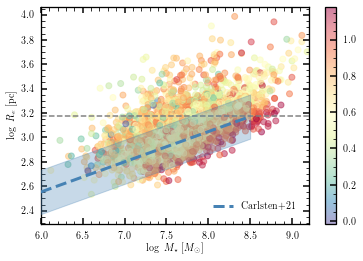

In [26]:
# Carlsten mass-size relation
def mass_size_carlsten(log_m):
    return 1.071 + 0.247 * log_m
x = np.linspace(6, 8.5)
plt.fill_between(x, mass_size_carlsten(x) - 0.181, 
                 mass_size_carlsten(x) + 0.181, 
                 color='steelblue', alpha=0.3, zorder=10)
plt.plot(x, mass_size_carlsten(x), ls='--', 
         color='steelblue', lw=3, label='Carlsten+21', zorder=10)

plt.scatter(cuts_cat['log_m_star'], 
            np.log10(cuts_cat['rhalf_phys']) + 3, 
            c=cuts_cat['g-i'], cmap='Spectral_r', alpha=0.5, zorder=1)
plt.colorbar()

plt.xlabel(r'$\log\ M_\star\ [M_\odot]$')
plt.ylabel(r'$\log\ R_{e}\ [\rm pc]$')
plt.legend(loc='lower right')

plt.xlim(6., 9.2)

plt.axhline(np.log10(1500), ls='--', color='gray')

In [28]:
# error not included
thresh = 1.5

flag = (np.log10(cuts_cat['rhalf_phys']) + 3 - mass_size_carlsten(cuts_cat['log_m_star'])) > 0.181 * thresh

print('# of UDGs:', np.sum(flag))

# of UDGs: 362


In [29]:
udg_cat = cuts_cat[flag]

In [30]:
junk = (udg_cat['bad_votes'] > udg_cat['good_votes'])
candy = (udg_cat['good_votes'] > udg_cat['bad_votes']) & (
    udg_cat['is_candy'] > udg_cat['is_galaxy'])
gal = (~junk) & (~candy)
print('# of Candy:', np.sum(candy))
print('# of Gal:', np.sum(gal))
print('# of Junk:', np.sum(junk))

# of Candy: 300
# of Gal: 46
# of Junk: 16


In [31]:
udg_cat[['viz-id', 'ra', 'dec']].write(
    f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_spergel_w_missed.txt', 
    format='ascii', overwrite=True)

---
### Visual inspection: mark junks

In [92]:
cuts_cat[cuts_cat['viz-id'] == 27138]

viz-id,ra,dec,image_flag,psf_flag,radius,flux,mag,mag_err,g-i,g-i_err,g-r,g-r_err,SB_eff_avg,SB_eff_avg_err,rhalf_spergel,rhalf_spergel_err,rhalf_phys,rhalf_phys_err,abs_mag,abs_mag_err,log_ML_g,log_ML_g_err,log_m_star,log_m_star_err,completeness,tract,patch,synth_id,mag_auto_g,mag_auto_r,mag_auto_i,flux_radius_ave_g,flux_radius_ave_i,A_g,A_r,A_i,is_candy,is_galaxy,is_tidal,is_outskirts,is_cirrus,is_junk,num_votes,good_votes,bad_votes,host_name,host_z,host_ang_diam_dist,host_stellar_mass,host_halo_mass,host_r_vir,host_r_vir_ang,host_300kpc_ang,host_gi,host_nvotes,host_spiral,host_elliptical,host_uncertain,host_RA,host_DEC,SB_eff_circ,SB_0,ell_cen,ell_sym,PA_cen,PA_sym,rhalf_circularized,spergel_nu,r20,r50,r80,Gini,M20,"F(G,M20)","S(G,M20)",C,A,S,A_outer,A_shape,sersic_n,sersic_rhalf,sersic_ell,sersic_PA,flag_sersic
,deg,deg,,,arcmin,,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),arcsec,arcsec,kpc,kpc,mag(AB),mag(AB),,,,,,,,,,,,,,,,,,,,,,,,,,,,Mpc,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
int64,float64,float64,bool[5],bool[5],float64,float64[4],float64[3],float64[3],float64,float64,float64,float64,float64[3],float64[3],float64,float64,float64,float64,float64[3],float64[3],float64,float64,float64,float64,float64,int64,bytes3,int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64,int64,int64,int64,int64,bytes19,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64[4],float64[4],float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
27138,129.6172269,-2.0361118,True .. True,True .. True,0.7,3107.171529303415 .. 5323.259768107851,18.29258846691606 .. 17.83328862470843,0.05 .. 0.05,0.4210062541386294,0.05,0.09154273930190865,0.05,23.56603804310679 .. 23.10673820089916,0.05 .. 0.05,4.5248061812148315,0.3,3.6280903397764077,0.2405466794249955,-17.966895443767555 .. -18.426195285975187,0.05 .. 0.05,-0.4647790344303059,0.06485,8.733979143076716,0.06786400002947071,0.9003512610559079,9071,"3,5",-1,19.1034,18.7994,18.5842,4.326924,4.5402000000000005,0.0774738236715193,0.054900256737225706,0.03918023560251595,2,0,0,0,0,0,2,2,0,J083901.30-015713.9,0.03919384256005287,165.38786943865566,10.941068976649866,12.826621055603027,486.0260756355005,0.1683753693825338,0.10392983699220804,1.3175234198570251,--,--,--,--,129.75536183317658,-1.9539365674169382,24.617568066526363 .. 24.03303698942125,22.809702515293992 .. 22.22517143818888,0.6263153230058673,0.6263154135804238,1.173887801248815,1.1738878270651922,4.641467574253704,0.754046954098008,14.419156678739274,29.7490327931088,54.06929265297823,0.4977684464407912,-1.720648224020663,-0.3036369708717639,-0.07337934116248895,2.870054135833933,0.00048807893126161234,0.01913855448287391,0.001168832820981316,0.17897864369745842,0.8996924238034252,46.05465415186337,0.6493875992506344,1.1796841571321004,0.0


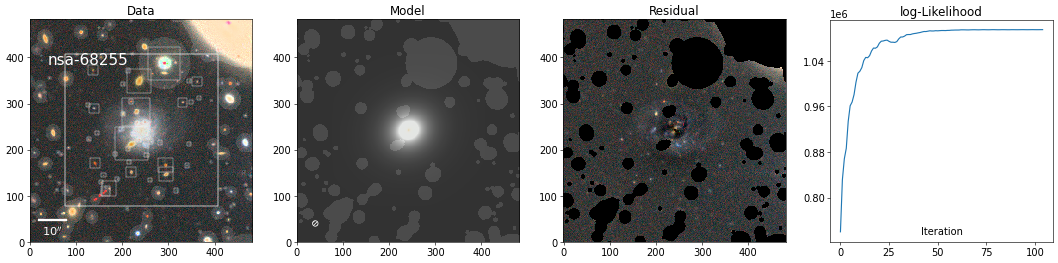

In [93]:
method = 'spergel'
Image.open(f'./Figure/nsa_z002_004/{method}/nsa-68255-zoomin-{method}.png')

In [43]:
votes = Table.read(f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_votes_w_missed.txt',
                   format='ascii')
flag = ~(votes['marked'] == 'true')

In [44]:
udg_cat = udg_cat[flag]

In [45]:
print('Hosts for LSBGs after cuts:', len(np.unique(cuts_cat['host_name'])))
print('')
print('LSBGs after cuts:', len(cuts_cat))
print('UPGs:', len(udg_cat))
print('UPG hosts:', len(np.unique(udg_cat['host_name'])))

print('UPG fraction:', len(udg_cat) / len(np.unique(cuts_cat['host_name'])))
## SAGA UDG fraction: 1/6 = 0.167
junk = (udg_cat['bad_votes'] > udg_cat['good_votes'])
candy = (udg_cat['good_votes'] > udg_cat['bad_votes']) & (
    udg_cat['is_candy'] > udg_cat['is_galaxy'])
gal = (~junk) & (~candy)
print('')
print('# of Candy:', np.sum(candy))
print('# of Gal:', np.sum(gal))
print('# of Junk:', np.sum(junk))

Hosts for LSBGs after cuts: 689

LSBGs after cuts: 2510
UPGs: 341
UPG hosts: 241
UPG fraction: 0.4949201741654572

# of Candy: 292
# of Gal: 41
# of Junk: 8


In [46]:
(udg_cat['completeness'] > 0.1).sum()

337

In [47]:
udg_cat.write(f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_spergel_after_viz_{thresh}sigma.fits', 
              overwrite=True)
udg_cat[['viz-id', 'ra', 'dec']].write(
    f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_spergel_after_viz_{thresh}sigma.txt', 
    format='ascii', overwrite=True)

### Then 2 sigma definition

In [48]:
# error not included
thresh = 2

flag = (np.log10(udg_cat['rhalf_phys']) + 3 - mass_size_carlsten(udg_cat['log_m_star'])) > 0.181 * thresh

print('# of UPGs:', np.sum(flag))

# of UPGs: 157


In [49]:
udg_cat = udg_cat[flag]

junk = (udg_cat['bad_votes'] > udg_cat['good_votes'])
candy = (udg_cat['good_votes'] > udg_cat['bad_votes']) & (
    udg_cat['is_candy'] > udg_cat['is_galaxy'])
gal = (~junk) & (~candy)
print('# of Candy:', np.sum(candy))
print('# of Gal:', np.sum(gal))
print('# of Junk:', np.sum(junk))

# of Candy: 133
# of Gal: 20
# of Junk: 4


In [50]:
udg_cat.write(f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_spergel_after_viz_{thresh}sigma.fits', 
              overwrite=True)
udg_cat[['viz-id', 'ra', 'dec']].write(
    f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_spergel_after_viz_{thresh}sigma.txt', 
    format='ascii', overwrite=True)

In [51]:
len(udg_cat)

157

---

---